# Concepts

This tutorial makes you familiar with basic concepts of pairinteraction's Python interface. It provides insights how the pairinteraction library is structured and how to use it.

## Structure of the pairinteraction Library

The library is structured around Python classes that can be used to model systems of Rydberg atoms. Typically, we start a simulation by describing in which atomic state we are interested. For this, the following class is available:

* `KetAtom` (see also Section 5 bellow): State of a single Rydberg atom, constructed from quantum numbers (if the specified quantum numbers do not match any of the pre-calculated states precisely, the closest state is used). You can display information about a state by using Python's `print` function on a `KetAtom` object. This class also provides methods to get properties of the state such as its energy or lifetime.

For modelling a single atom, the following classes are available:

* `BasisAtom` (see also Section 6a bellow): Basis of the single-atom Hilbert space, constructed from ranges of quantum numbers. The basis is initialized as the canonical basis of the Hilbert space, i.e., the basis is made up of basis vectors that each have a single non-zero element corresponding to a particular `KetAtom` state.

* `SystemAtom` (see also Section 6b bellow): System of a single Rydberg atom, constructed from a `BasisAtom` and the electric and magnetic fields acting on the atom. The class provides access to the atom's Hamiltonian.

Two single-atom systems can be combined to model a pair of atoms using the following classes:

* `BasisPair` (see also Section 7a bellow): Basis of a pair of atoms, constructed from two `SystemAtom` objects. For constructing the basis, the eigenstates of the Hamiltonians of the two atoms are used. The basis is initialized as the canonical basis where each basis vector has a single non-zero element corresponding to a tensor product of the eigenstates. The energy of the state, that is described by such a basis vector, is the sum of the eigenenergies. To keep the basis size manageable, you can truncate it by specifying an energy range.

* `SystemPair` (see also Section 7b bellow): System of a pair of atoms, constructed from a `BasisPair` and the interaction between the atoms. This class provides access to the two-atom Hamiltonian.

### Helper Functions

In addition, the library provides helper functions to improve the visualization of pair potentials, calculate effective Hamiltonians, or properties of a system such as $C_3$ or $C_6$ coefficients. Moreover, we provide a helper function that can be used to diagonalize the Hamiltonians of several systems in parallel.

### Convenience Functionality

To make the library easier to use, we have added some convenience functionality:

* **Unit Conversions:** Many methods accept a `unit` parameter, such as `set_electric_field` and `get_eigenenergies`. This parameter allows you to chose in which units you want to set or obtain values by specifying the unit as a string, for example, `unit="V/cm"`. The pairinteraction software automatically performs the required unit conversions. It uses the spectroscopy context of the [pint library](https://github.com/hgrecco/pint), so that energies can also be expressed in frequency units or wave numbers.

* **Strict Typing:** The library makes extensive use of Python's type annotations. This has two advantages for you: First, you can directly see what types of arguments are expected for a function. Second, if you use a Python development environment that supports type checking, you will get warnings if you pass the wrong type of argument to a function.

* **Code Completion:** The Python API of pairinteraction is designed so that code completion should work in Python development environments. For example, if you type `pi.BasisAtom(` and then press `Ctrl+Space` in Visual Studio Code, you should see a list of available arguments for the `BasisAtom` constructor.




## Modelling Rydberg Systems

In the following, we show steps for modelling systems of one or two Rydberg atoms using the pairinteraction library.

### 1. Choose a Datatype

Before you can use the pairnteraction library to study Rydberg atoms, you must decide whether you want to use real or complex numbers to represent the Hamiltonian of your system. In general, real numbers are sufficient if no fields or interactions are applied along the y-direction. After you have chosen a datatype, you can import the corresponding backend. In the following, we use the backend for real numbers. Changing the backend might require restarting the Jupyter kernel.

In [1]:
import pairinteraction.real as pi  # possible backend data types: real, complex

To improve the output of the Jupyter notebook, we limit the number of values that will be shown if we print a numpy array.

In [2]:
import numpy as np

np.set_printoptions(linewidth=120, threshold=10)

### 2. Optionally, Configure Logging

The pairinteraction software supports Python's logging module. You can adopt the following code to configure the log level and output format:

In [3]:
import logging

logging.basicConfig(
    level=logging.WARNING,
    format="%(levelname)-8s [%(asctime)s.%(msecs)03d] [%(filename)s:%(lineno)d] %(message)s",
    datefmt="%H:%M:%S",
)

### 4. Set up the Database

The `Database` object is responsible for storing and looking up the allowed atomic states with their corresponding energies, quantum numbers and electric dipole, etc. matrix elements with other atomic states.
These matrix elements are pre-calculated (either via explicit calculation of the overlap integrals and using the Numerov method to get the radial wavefunctions, or alternatively for Earth Alkali atoms via Multichannel Quantum Defect Theory (MQDT)) and stored online in their own github repositories \[[1](https://github.com/pairinteraction/database-sqdt/releases),[2](https://github.com/pairinteraction/database-mqdt/releases)\].
The `Database` object is able to download the necessary tables on the fly if `download_missing=True` is passed to the `Database`. Once downloaded, the tables are stored in the cache directory of the user's computer and are reused in subsequent calculations so that the software can be used without an internet connection.

You can either create a `Database` object via `database = pi.Database(download_missing=True)` and use this database for the creation of the kets and basis objects below,
or alternatively you can once create a global instance of the `Database` object via `pi.Database.initialize_global_database(download_missing=True)` and then the ket and basis classes will use this global instance by default.

In [5]:
if pi.Database.get_global_database() is None:
    pi.Database.initialize_global_database(download_missing=True)

### 3. Optionally, Run a Self-Test

The pairinteraction software includes self tests that checks if the pairinteraction python module is working correctly. You can run the tests as follows:

In [6]:
from pairinteraction import run_module_tests

database = pi.Database.get_global_database()
assert run_module_tests(database.download_missing, database.database_dir) == 0

### 5. Create an Atomic State (`KetAtom`)

The simplest object you can create is a simple ket via the `KetAtom` class, representing a single atomic state.

The first argument to the constructor of a `KetAtom` object has to be the specifier of the atomic species, for example, 'Rb', 'Sr88_singlet', 'Sr88_triplet', 'Sr87_mqdt', 'Sr88_mqdt', 'Yb171_mqdt', 'Yb174_mqdt'. Here, the ending `_mqdt' specifies that the matrix elements were calculated via multi-channel quantum defect theory (MQDT). Matrix elements of other species were calculated via single-channel quantum defect theory (SQDT) using the Numerov method to obtain radial wavefunctions. For a full list of supported species, see the "Identifier" column in the "quantum defect references" table of pairinteraction's [README](https://www.pairinteraction.org/pairinteraction/sphinx/html/index.html).

In addition, you must pass quantum numbers as keyword arguments to uniquely specify a state. You can pass whatever combination of quantum numbers you like, as long as they uniquely specify exactly one state (e.g. `pi.KetAtom("Rb", n=60, l=0, j=0.5, m=0.5)` and `pi.KetAtom("Rb", n=60, l=0, m=0.5)` are both equivalent and specify the same state).

In [7]:
ket = pi.KetAtom("Rb", n=60, l=1, j=0.5, m=0.5)

print(
    f"You successfully created a ket object: {ket} "
    f"with quantum numbers n={ket.n}, l={ket.l}, j={ket.j}, "
    f"m={ket.m} and energy={ket.get_energy()}"
)
print(f"And getting its energy in GHz is as simple as {ket.get_energy(unit='GHz')=}")

ket2 = pi.KetAtom("Rb", n=58, l=0, j=0.5, m=0.5)
delta_energy = ket.get_energy() - ket2.get_energy()  # this is a pint.Quantity object

print("\nEven the energy difference between two states is easily calculated and converted:")
print(f"delta_energy = {delta_energy}")
print(13 * " " + f"= {delta_energy.to('GHz', 'spectroscopy')} (as frequency)")
print(13 * " " + f"= {delta_energy.to('cm^-1', 'spectroscopy')} (as wavenumber)")
print(13 * " " + f"= {delta_energy.to('eV', 'spectroscopy')} ")
print(13 * " " + f"= {delta_energy.to('mm', 'spectroscopy')} (as wavelength)")

You successfully created a ket object: |Rb:60,P_1/2,1/2⟩ with quantum numbers n=60, l=1.0, j=0.5, m=0.5 and energy=0.15335520073991077 bohr ** 2 * electron_mass / atomic_unit_of_time ** 2
And getting its energy in GHz is as simple as ket.get_energy(unit='GHz')=1009028.7484337102

Even the energy difference between two states is easily calculated and converted:
delta_energy = 1.403362628490945e-05 bohr ** 2 * electron_mass / atomic_unit_of_time ** 2
             = 92.33682521314954 gigahertz (as frequency)
             = 3.0800249555694146 / centimeter (as wavenumber)
             = 0.0003818744252705271 electron_volt 
             = 3.2467269402858667 millimeter (as wavelength)


### 6a. Create a Single-Atom Basis (`BasisAtom`)

Next, you can create a basis object.
A basis object consists of a list of kets which define a canonical basis for the Hilbert space.
Furthermore, the basis object defines basis states via its coefficients matrix, where each column in the coefficients matrix corresponds to one basis state.
When created, the coefficients matrix is initialized to the identity matrix, i.e. each basis state correspond to one ket.
However, in general a state (and therefore each column of the basis coefficients matrix) can be a superposition of multiple kets.

The list of which kets should be considered in the basis can be restricted by passing to the `BasisAtom` class tuples of (min, max) values for the quantum numbers and energy.

In [8]:
basis = pi.BasisAtom("Rb", n=(ket.n - 3, ket.n + 3), l=(0, ket.l + 2))
coefficients = basis.get_coefficients()  # this is a scipy.sparse.csr_matrix object

print(f"This basis contains {basis.number_of_kets} kets (=atomic states)")
print(f"The first and last kets are {basis.kets[0]} and {basis.kets[-1]}")
print(f"The coefficient matrix has shape {coefficients.shape} and the following entries:")
print(f"{coefficients.toarray()}")

This basis contains 224 kets (=atomic states)
The first and last kets are |Rb:57,S_1/2,-1/2⟩ and |Rb:63,F_5/2,5/2⟩
The coefficient matrix has shape (224, 224) and the following entries:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


### 6b. Create a Single-Atom System (`SystemAtom`)

The `SystemAtom` object describes the single-atom system.
It is created by passing a `BasisAtom` object in, which defines the basis of the Hilbert space.
You can now set external fields and enable or disable the diamagnetic term. Then you can inspect the resulting Hamiltonian and diagonalize it to get the eigenstates and eigenenergies of the system.

In [9]:
system = pi.SystemAtom(basis)
system.set_magnetic_field([0, 0, 1], unit="gauss")
system.set_electric_field([0, 0, 0.1], unit="V/cm")
system.set_diamagnetism_enabled(True)

print("The Hamiltonian of the system with magnetic and electric fields is (in GHz):")
print(f"{system.get_hamiltonian(unit='GHz').toarray()}")

system.diagonalize()
eigenbasis = system.get_eigenbasis()
eigenenergies = system.get_eigenenergies(unit="GHz")

print("\nThe eigenenergies are (in GHz):")
print(eigenenergies)

eigenstate_number = 2

print(f"\nThe coefficients of the eigenstate with index {eigenstate_number} are:")
print(f"{eigenbasis.get_coefficients().toarray()[:, eigenstate_number]}")
print(
    "It has the largest overlap with the ket: "
    f"{eigenbasis.get_corresponding_ket(eigenstate_number)}"
)

corresponding_state = eigenbasis.get_corresponding_state(ket)

print(f"\nThe state corresponding to the ket {ket} is:")
print(f"{corresponding_state.get_coefficients().toarray().flatten()}")
print(f"The overlap |<state|ket>|^2 is {corresponding_state.get_overlaps(ket)[0]}")

The Hamiltonian of the system with magnetic and electric fields is (in GHz):
[[1.00889546e+06 0.00000000e+00 1.43360817e-01 ... 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00889547e+06 0.00000000e+00 ... 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.43360817e-01 0.00000000e+00 1.00891525e+06 ... 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00919985e+06 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00 1.00919985e+06 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00 0.00000000e+00 1.00919985e+06]]

The eigenenergies are (in GHz):
[1008895.45959262 1008895.46239512 1008915.24747166 ... 1009199.85399914 1009199.85504622 1009199.85630439]

The coefficients of the eigenstate with index 2 are:
[0.00725431 0.         0.99995281 ... 0.         0.         0.        ]
It has the largest overlap with the ket: |Rb:57,P_1/2,-1/2⟩

The sta

### 7a. Create a Two-Atom Basis (`BasisPair`)

The `BasisPair` object consists of a list of `KetPair` objects.
Again, we view these KetPair kets as forming a canonical basis for the pair Hilbert space.
However, in contrast to the `KetAtom` objects, the `KetPair` objects are not atomic states (or product states of atomic states), but rather product states of the eigenstates of the single atom Hamiltonian.

Again, the `BasisPair` object has a coefficients matrix, which defines the basis states (with respect to the list of `KetPair` objects).
The coefficients matrix is initialized to the identity matrix.
This corresponds to the eigenstates of the pair Hamiltonian with external fields but without any interaction between the atoms.
In general, when adding interactions, the pair-states (=the columns of the coefficent matrix) can be a superposition of multiple KetPair objects.

Similar to the `BasisAtom` object, we can restrict the list of kets that should be considered in the basis by passing in tuples of (min, max) values for the energy of the pair states and the quantum number m if it is conserved.


In [10]:
pair_energy = 2 * system.get_corresponding_energy(ket, unit="GHz")
delta_energy = 10  # GHz
pair_basis = pi.BasisPair(
    [system, system],
    m=(2 * ket.m, 2 * ket.m),
    energy=(pair_energy - delta_energy, pair_energy + delta_energy),
    energy_unit="GHz",
)
coefficients = pair_basis.get_coefficients()

print(f"The pair-basis contains {pair_basis.number_of_kets} KetPair (=pair-states)")
print(
    "The first KetPair corresponds to a pair-state "
    f"close to the product state {pair_basis.kets[0]}"
)
print(f"The coefficient matrix has shape {coefficients.shape} and the following entries:")
print(f"{coefficients.toarray()}")

The pair-basis contains 418 KetPair (=pair-states)
The first KetPair corresponds to a pair-state close to the product state |Rb:57,S_1/2,-1/2; Rb:63,D_3/2,3/2⟩
The coefficient matrix has shape (418, 418) and the following entries:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


### 7b. Create a Two-Atom System (`SystemPair`)

The `SystemPair` object describes the pair system.
Similar to the `SystemAtom` object, it is created by passing a `BasisPair` object in, which defines the basis of the pair Hilbert space.
You can now set the interatomic distance between the atoms and the order of the multipole expansion.
Then you can inspect the resulting Hamiltonian and diagonalize it to get the eigenstates and eigenenergies of the system.

In [11]:
pair_system = pi.SystemPair(pair_basis)
distance = 5  # micrometer
pair_system.set_distance(distance, unit="micrometer")
pair_system.set_interaction_order(3)

print(f"The Hamiltonian of the SystemPair (in GHz) for the given {distance=}um is:")
print(f"{pair_system.get_hamiltonian(unit='GHz').toarray()}")

pair_system.diagonalize()
eigenenergies = pair_system.get_eigenenergies(unit="GHz")

print("\nThe eigenenergies in GHz are:")
print(eigenenergies)

The Hamiltonian of the SystemPair (in GHz) for the given distance=5um is:
[[ 2.01805910e+06  1.52736742e-05 -1.51202166e-11 ...  0.00000000e+00 -1.56814085e-12  0.00000000e+00]
 [ 1.52736742e-05  2.01805914e+06 -2.41449015e-12 ...  0.00000000e+00  6.42749478e-12  0.00000000e+00]
 [-1.51202166e-11 -2.41449015e-12  2.01805910e+06 ... -1.80795603e-12  1.21480123e-11  7.41044909e-12]
 ...
 [ 0.00000000e+00  0.00000000e+00 -1.80795603e-12 ...  2.01805910e+06 -7.73868826e-12  1.52736742e-05]
 [-1.56814085e-12  6.42749478e-12  1.21480123e-11 ... -7.73868826e-12  2.01805914e+06 -1.08294737e-11]
 [ 0.00000000e+00  0.00000000e+00  7.41044909e-12 ...  1.52736742e-05 -1.08294737e-11  2.01805914e+06]]

The eigenenergies in GHz are:
[2018047.72490338 2018047.72490675 2018048.01560259 ... 2018067.37013015 2018067.37253401 2018067.37552607]


## Analyzing Rydberg Systems

Once you have created a `KetAtom`, `SystemAtom`, or `SystemPair` object, you can use different methods to obtain information about the object.

For example, you can obtain the eigenenergies of a system to plot Stark maps, Zeeman maps, or pair potentials. Because this requires diagonalizing Hamiltonians of many systems for different parameters, we provide a function
```python
pi.diagonalize
```
that can be used to diagonalize the Hamiltonians in parallel. This function is implemented in C++ and thus avoids Python's global interpreter lock (GIL). To accelerate the diagonalization, you can reduce the precision by passing `float_type="float32"` as an argument. The resulting numerical errors are typically negligible. A further speedup can be achieved by using `diagonalizer="lapacke_evr"` to compute eigenenergies only in a specified energy range, for example, by passing `energy=(-1, 1), energy_unit="MHz"` to the `diagonalize` function. The relative error in the eigenenergies can be controlled by setting `rtol` (the default is 1e-6, which is usually sufficient and compatible with float32). In the following, we demonstrate how this function can be used to obtain pair potentials.

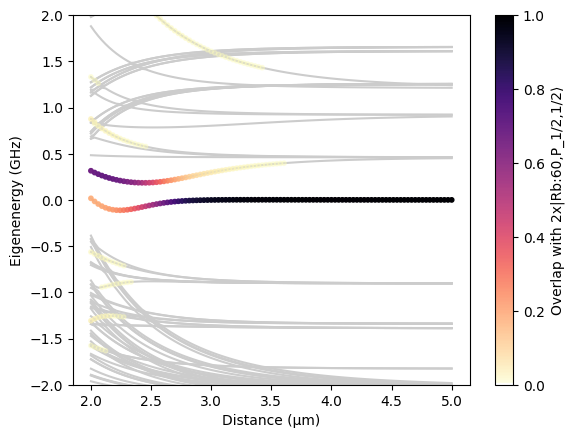

In [14]:
import matplotlib.pyplot as plt
from pairinteraction.visualization.colormaps import alphamagma

# Use pair basis from before to construct systems with different distances between atoms
distances = np.linspace(2, 5, 100)  # micrometer
pair_systems = [
    pi.SystemPair(pair_basis).set_distance(d, unit="micrometer") for d in distances
]

# Diagonalize all systems in parallel and get the eigenenergies and overlaps
pi.diagonalize(pair_systems, float_type="float32")
pair_eigenenergies = np.array([s.get_eigenenergies(unit="GHz") for s in pair_systems])
pair_overlaps = np.array([s.get_eigenbasis().get_overlaps([ket, ket]) for s in pair_systems])

# Plot the eigenenergies  and overlaps as a function of distance
distances_repeated = np.hstack(
    [d * np.ones_like(e) for d, e in zip(distances, pair_eigenenergies)]
)
pair_eigenenergies_flattened = np.hstack(pair_eigenenergies)
pair_overlaps_flattened = np.hstack(pair_overlaps)
sorter = np.argsort(pair_eigenenergies_flattened)

plt.plot(distances, pair_eigenenergies - pair_energy, "-", color="0.8", zorder=-10)
scat = plt.scatter(
    distances_repeated[sorter],
    pair_eigenenergies_flattened[sorter] - pair_energy,
    c=pair_overlaps_flattened[sorter],
    s=10,
    cmap=alphamagma,
    vmin=0,
    vmax=1,
)
plt.colorbar(scat, label=f"Overlap with 2x{ket}")
plt.xlabel("Distance (μm)")
plt.ylabel("Eigenenergy (GHz)")
plt.ylim(-2, 2)
plt.show()

Example applications and additional ways to analyze systems are described in the next tutorials.